**SOLUTION IS BASED ON QISKIT DEFAULTS CATEGORY**

**1.1) Implementing the circuit**

Here we implement the circuit as shown in the jupyter notebook provided in the github documents of the competition.
The intention behind doing this is to set a datum for further improvement.<br><br>
We have tried to determine the highest number of possible Trotter steps that can be created where the fidelity shows an increasing trend.
This number turned out to be $n=9$ Trotter steps, after which the fidelity does increase with the number of Trotter steps.<br><br>
Although this satisfies the minimum Trotter step criteria $n \ge 4$, it however does not satisfy the minimum fidelity criteria ($\ge 30 \%$) even for the ${noisy \ simulator}$.<br><br>

In the code only the solution for $n=9$ Trotter steps is presented.


In [1]:
import qiskit

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size' : 16})

#Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Z

#Supress Warnings
import warnings
warnings.filterwarnings('ignore')

**1.2) The XXX Heisenberg Hamiltonian**

In [2]:
#Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    #interaction  (I is the idenstity matrix; X, Y and Pauli matrices; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    #Sum interactions
    H = XXs + YYs + ZZs
    
    #Return Hamiltonian
    return H

In [3]:
#Returns the matrix representation of U_heis3(t) foragiven time t assuming a XXX Heisenberg Hamiltonian for 3 spin-1/2 particles in a line
def U_heis3(t):
    #Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3
    
    #Return the exponential of -i multiplied by time t multiplied by the 3 spin XXX Heisenberg Hamiltonian
    return (t * H).exp_i()

In [2]:
#Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

#Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
provider = IBMQ.load_account()

In [4]:
#get backend for experiment
provider = IBMQ.get_provider(hub = 'ibm-q-community', group = 'ibmquantumawards', project = 'open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

#simulated backend based on ibmq-jakarta's noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

#noiseless simulated backend
sim = QasmSimulator

**1.3) The 6-CNOT gate approach**

This approach was presented in the example notebook. To determine the efficiancy of this approach I have increased the number of Trotter steps and find the upper bound where it gives maximum fidelity. For this circuit the maximum number of Trotter steps for which the fidelity increases linearly is $n = 9$

In [89]:
t = Parameter('t')
n = 9

In [90]:
#Build a subcircuit for the XX(t) two-qubit gate
XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name = 'XX')

XX_qc.ry(np.pi/2, [0,1])
XX_qc.cnot(0,1)
XX_qc.rz((2 * t)/n, 1)
XX_qc.cnot(0,1)
XX_qc.ry(-np.pi/2, [0,1])

#Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

In [91]:
#Build a subcircuit for the YY(t) two-qubit gate
YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name = 'YY')

YY_qc.rx(np.pi/2, [0, 1])
YY_qc.cnot(0, 1)
YY_qc.rz((2 * t)/n, [0,1])
YY_qc.cnot(0, 1)
YY_qc.rx(-np.pi/2, [0, 1])

#Convert custom quantum circuit into Quantum gate
YY = YY_qc.to_instruction()

In [92]:
#Build subcircuit for ZZ(t) two-qubit gate
ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name = 'ZZ')

ZZ_qc.cnot(0, 1)
ZZ_qc.rz((2 * t)/n, 1)
ZZ_qc.cnot(0, 1)

#Convert custom quantum circuit into Quantum gate
ZZ = ZZ_qc.to_instruction()

In [93]:
#Combine subcircuits into single multiqubit gate representaing single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name = 'Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i + 1]])
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i + 1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i + 1]])
    
#Convert custom quantum Circuit into a gate
Trot_gate = Trot_qc.to_instruction()

In [94]:
#The final time of the state evolution
target_time = np.pi

#Number of Trotter steps
trotter_steps = 9

#Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

#Prepare initial step
qc.x([3, 5])

#Simulate time evolution under H_Heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
#Evaluate simulation at target_time(t=pi)
qc = qc.bind_parameters({t: target_time/ trotter_steps})

#Generate state tomography circuitsto evaluate the fidelity of the simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

#Display circuit for confirmation
st_qcs[-1].decompose().draw() #view decomposition of trotter gates
st_qcs[-1].draw()

»
q86560_0: ─────────────────────────────────────────────────────────────»
               ┌────────────┐┌────────────┐┌────────────┐┌────────────┐»
q86560_1: ─────┤0           ├┤0           ├┤0           ├┤0           ├»
               │            ││            ││            ││            │»
q86560_2: ─────┤            ├┤            ├┤            ├┤            ├»
          ┌───┐│            ││            ││            ││            │»
q86560_3: ┤ X ├┤1 Trot(π/9) ├┤1 Trot(π/9) ├┤1 Trot(π/9) ├┤1 Trot(π/9) ├»
          └───┘│            ││            ││            ││            │»
q86560_4: ─────┤            ├┤            ├┤            ├┤            ├»
          ┌───┐│            ││            ││            ││            │»
q86560_5: ┤ X ├┤2           ├┤2           ├┤2           ├┤2           ├»
          └───┘└────────────┘└────────────┘└────────────┘└────────────┘»
q86560_6: ─────────────────────────────────────────────────────────────»
                                                                       »
    c9: 3/═════════════════════════════════════════════════════════════»
                                                                       »
«                                                                  »
«q86560_0: ────────────────────────────────────────────────────────»
«          ┌────────────┐┌────────────┐┌────────────┐┌────────────┐»
«q86560_1: ┤0           ├┤0           ├┤0           ├┤0           ├»
«          │            ││            ││            ││            │»
«q86560_2: ┤            ├┤            ├┤            ├┤            ├»
«          │            ││            ││            ││            │»
«q86560_3: ┤1 Trot(π/9) ├┤1 Trot(π/9) ├┤1 Trot(π/9) ├┤1 Trot(π/9) ├»
«          │            ││            ││            ││            │»
«q86560_4: ┤            ├┤            ├┤            ├┤            ├»
«          │            ││            ││            ││            │»
«q86560_5: ┤2           ├┤2           ├┤2           ├┤2           ├»
«          └────────────┘└────────────┘└────────────┘└────────────┘»
«q86560_6: ────────────────────────────────────────────────────────»
«                                                                  »
«    c9: 3/════════════════════════════════════════════════════════»
«                                                                  »
«                         ░          
«q86560_0: ───────────────░──────────
«          ┌────────────┐ ░ ┌─┐      
«q86560_1: ┤0           ├─░─┤M├──────
«          │            │ ░ └╥┘      
«q86560_2: ┤            ├─░──╫───────
«          │            │ ░  ║ ┌─┐   
«q86560_3: ┤1 Trot(π/9) ├─░──╫─┤M├───
«          │            │ ░  ║ └╥┘   
«q86560_4: ┤            ├─░──╫──╫────
«          │            │ ░  ║  ║ ┌─┐
«q86560_5: ┤2           ├─░──╫──╫─┤M├
«          └────────────┘ ░  ║  ║ └╥┘
«q86560_6: ───────────────░──╫──╫──╫─
«                         ░  ║  ║  ║ 
«    c9: 3/══════════════════╩══╩══╩═
«                            0  1  2

In [95]:
shots = 16000
reps = 8
backend = sim_noisy_jakarta

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 54d8c9f8-0b37-4c46-82c4-facea537d584
Job ID 8d38e95a-2c1b-408d-883f-de34ffac536a
Job ID f947f70f-7dcb-4bd4-8326-b63539db4e05
Job ID 9e206d7f-f90a-4393-9e14-cfbd51e59778
Job ID 7741d489-6a45-470e-bb61-aa19f05e9410
Job ID 1fbd4182-8d02-4324-90c7-6ccc708dad7f
Job ID 10ca757c-3132-4d4b-a177-20f056fdde7e
Job ID e936ba62-895b-4547-8122-6cebfe82732a


In [96]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


**1.4) State Tomography Fidelity**

Here we calculate the fidelities of the 6-CNOT circuit by increasing the number of Trotter steps $n = 9$ as well as increasing the number of shots to 16000.

In [97]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.2789 ± 0.0013


In [71]:
shots = 16000
reps = 8
backend = QasmSimulator.from_backend(backend)

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 922c3284-cd80-4c5a-b7b9-5fcf102b9b41
Job ID e3399282-32dd-4663-b9a7-08bfd50011c0
Job ID bb514347-3a3a-4c26-8f96-d1b20e9bed88
Job ID 28828837-bed7-448c-94e5-96873f21d154
Job ID 735e93dd-030a-4522-b615-5b48a4442ee2
Job ID 525610eb-a3db-4296-a5f9-783b546baf88
Job ID ca81ed85-72ec-448a-a528-19b31829c9f7
Job ID 548ed6e9-0a58-435c-8d9e-07872b1446c4


In [72]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [73]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.2792 ± 0.0011


In [98]:
from qiskit import Aer
shots = 16000
reps = 8
backend = Aer.get_backend('aer_simulator')

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID d0b22b36-d04d-48a7-862e-8c8bc94f5405
Job ID a277c42c-b9e9-4373-9ca4-7cb99462bfb0
Job ID 15d63bbb-9b20-4af7-b0ed-a22c6fcbb9df
Job ID b10176bf-8642-4442-9d9c-9eb4b346361d
Job ID 814172f3-7933-4b23-ae94-4484bd742bb3
Job ID 5b1a2a91-2910-4cd2-bea3-70a136fd50c2
Job ID a20c0537-cab7-4ce6-9707-3e2a38777843
Job ID c740a3db-5dee-4979-b3f7-93b16669be7d


In [99]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [100]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.4633 ± 0.0015


**2.1) Improved Circuit with 3-CNOT gates.**

In this section I have changed the circuit by reducing the number of gates and espicially reducing the number of CNOT gates.This approcah is taken from[1]. It uses the gates with cross-resnonance interactions consisting a native universal set,<br>
$$
{S_{1}} = \{R_{\alpha}\theta, CNOT\}
$$
containing single qubit rotations and two qubit CNOT gates.

Here I am exploring the fidelity results with differnet number of Trotter steps starting with $n = 10$.

In [5]:
t = Parameter('t')
n = 10

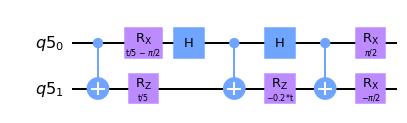

In [11]:
H_qr = QuantumRegister(2)
H_qc = QuantumCircuit(H_qr)

H_qc.cnot(0, 1)
H_qc.rx(((2 * t)/n - np.pi/2), 0)
H_qc.rz((2 * t)/n, 1)
H_qc.h(0)
H_qc.cnot(0, 1)
H_qc.h(0)
H_qc.rz(-(2 * t)/n, 1)
H_qc.cnot(0, 1)
H_qc.rx(np.pi/2, 0)
H_qc.rx(-(np.pi/2), 1)

#Covnert custom quantum circuit into a gate
H = H_qc.to_instruction()
H_qc.draw('mpl')

In [13]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr)

for i in range(0, num_qubits - 1):
    Trot_qc.append(H, [Trot_qr[i], Trot_qr[i + 1]])
    
#Convert custom Quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

In [15]:
#The final time of the state evolution
target_time = np.pi

#Number of Trotter steps
trotter_steps = 10

#Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

#Prepare initial step
qc.x([3, 5])

#Simulate time evolution under H_Heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
#Evaluate simulation at target_time(t=pi)
qc = qc.bind_parameters({t: target_time/ trotter_steps})

#Generate state tomography circuitsto evaluate the fidelity of the simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

#Display circuit for confirmation
st_qcs[-1].decompose().draw() #view decomposition of trotter gates
st_qcs[-1].draw()

»
q9_0: ───────────────────────────────────────────────────»
           ┌─────────────────────┐┌─────────────────────┐»
q9_1: ─────┤0                    ├┤0                    ├»
           │                     ││                     │»
q9_2: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q9_3: ┤ X ├┤1 circuit-1028(π/10) ├┤1 circuit-1028(π/10) ├»
      └───┘│                     ││                     │»
q9_4: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q9_5: ┤ X ├┤2                    ├┤2                    ├»
      └───┘└─────────────────────┘└─────────────────────┘»
q9_6: ───────────────────────────────────────────────────»
                                                         »
c1: 3/═══════════════════════════════════════════════════»
                                                         »
«                                                                           »
«q9_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q9_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q9_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q9_3: ┤1 circuit-1028(π/10) ├┤1 circuit-1028(π/10) ├┤1 circuit-1028(π/10) ├»
«      │                     ││                     ││                     │»
«q9_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q9_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q9_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c1: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q9_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q9_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q9_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q9_3: ┤1 circuit-1028(π/10) ├┤1 circuit-1028(π/10) ├┤1 circuit-1028(π/10) ├»
«      │                     ││                     ││                     │»
«q9_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q9_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q9_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c1: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                     ░          
«q9_0: ───────────────────────────────────────────────░──────────
«      ┌─────────────────────┐┌─────────────────────┐ ░ ┌─┐      
«q9_1: ┤0                    ├┤0                    ├─░─┤M├──────
«      │                     ││                     │ ░ └╥┘      
«q9_2: ┤                     ├┤                     ├─░──╫───────
«     

In [16]:
shots = 8192
reps = 8
backend = sim_noisy_jakarta

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID e6ee0fca-6cd4-4836-8c05-91478fbeb91c
Job ID ce96a54f-c42d-4213-b2a2-2ce6f6f9dca4
Job ID 4b708f12-7b26-4c13-a51b-b9d14c43464b
Job ID c4e85d03-6989-40f0-ad44-25a29cb9a1c2
Job ID 569a10ef-3660-410b-8d3b-660a14c46fb2
Job ID 9c8e1f75-c900-4ab8-9dba-3b68e7727cb4
Job ID acde9cef-c78f-4eeb-b1a5-55818621b3e7
Job ID 587c9d4d-3e3e-4476-ae6d-0abaf82acf7e


In [17]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


**2.1a) State Tomography Fidelity on noisy Simulator.**

In [18]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.4402 ± 0.0017


Increasing the number of Trotter Steps to $n = 12$.

In [5]:
t = Parameter('t')
n = 12

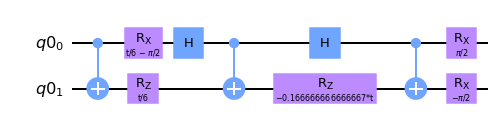

In [6]:
H_qr = QuantumRegister(2)
H_qc = QuantumCircuit(H_qr)

H_qc.cnot(0, 1)
H_qc.rx(((2 * t)/n - np.pi/2), 0)
H_qc.rz((2 * t)/n, 1)
H_qc.h(0)
H_qc.cnot(0, 1)
H_qc.h(0)
H_qc.rz(-(2 * t)/n, 1)
H_qc.cnot(0, 1)
H_qc.rx(np.pi/2, 0)
H_qc.rx(-(np.pi/2), 1)

#Covnert custom quantum circuit into a gate
H = H_qc.to_instruction()
H_qc.draw('mpl')

In [7]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr)

for i in range(0, num_qubits - 1):
    Trot_qc.append(H, [Trot_qr[i], Trot_qr[i + 1]])
    
#Convert custom Quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

In [8]:
#The final time of the state evolution
target_time = np.pi

#Number of Trotter steps
trotter_steps = 12

#Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

#Prepare initial step
qc.x([3, 5])

#Simulate time evolution under H_Heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
#Evaluate simulation at target_time(t=pi)
qc = qc.bind_parameters({t: target_time/ trotter_steps})

#Generate state tomography circuitsto evaluate the fidelity of the simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

#Display circuit for confirmation
st_qcs[-1].decompose().draw() #view decomposition of trotter gates
st_qcs[-1].draw()

»
q2_0: ───────────────────────────────────────────────────»
           ┌─────────────────────┐┌─────────────────────┐»
q2_1: ─────┤0                    ├┤0                    ├»
           │                     ││                     │»
q2_2: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q2_3: ┤ X ├┤1 circuit-1055(π/12) ├┤1 circuit-1055(π/12) ├»
      └───┘│                     ││                     │»
q2_4: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q2_5: ┤ X ├┤2                    ├┤2                    ├»
      └───┘└─────────────────────┘└─────────────────────┘»
q2_6: ───────────────────────────────────────────────────»
                                                         »
c0: 3/═══════════════════════════════════════════════════»
                                                         »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_3: ┤1 circuit-1055(π/12) ├┤1 circuit-1055(π/12) ├┤1 circuit-1055(π/12) ├»
«      │                     ││                     ││                     │»
«q2_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q2_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c0: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_3: ┤1 circuit-1055(π/12) ├┤1 circuit-1055(π/12) ├┤1 circuit-1055(π/12) ├»
«      │                     ││                     ││                     │»
«q2_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q2_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c0: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤    

In [23]:
shots = 8192
reps = 8
backend = sim_noisy_jakarta

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 89699251-3b0a-4c06-b31a-430ddd74083a
Job ID 10fe41a6-cf76-43c4-8619-aec87062d2d1
Job ID 890d55f6-7dd6-4d98-aca8-f899beff3095
Job ID 4c6ef054-173d-4e0a-8324-e1010a01ecde
Job ID 9d7be6b4-3eeb-4462-8add-d47664f9f97f
Job ID 6c4e0af3-6452-461c-9c53-81e55c1fd7e4
Job ID 0399106f-70f5-4ad7-8ee5-d2314b401fde
Job ID e4ae6a1d-5344-42e9-82fe-c812567be48d


In [24]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


**2.1b) Improved State Tomography Fidelity for the noisy simulator.**

In [25]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.4477 ± 0.0025


In [26]:
shots = 8192
reps = 8
backend = QasmSimulator.from_backend(backend)

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID daa02634-6002-4f96-9334-5e118a86d2ae
Job ID 8644a44c-9d79-451f-b547-d8a891785ebe
Job ID 212f1c1d-dd4f-455b-ab16-7f646abe61d5
Job ID 9af82652-46a4-4191-b6ee-3b243e886843
Job ID 935dad2f-73bd-4bd8-9a5d-d85ac1dec242
Job ID 7b31406d-6672-4ae6-9d0c-056ac4b0427a
Job ID b660f86e-f8ba-4a03-b042-abcdd8975dcb
Job ID b5d4bfda-3dc9-475c-a1fd-e31c62a29072


In [27]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [28]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.4480 ± 0.0023


**2.1c) State Tomography Fidelity For Ideal Simulators such as Aer and Qasm simulators.**

In [29]:
from qiskit import Aer, transpile

shots = 8192
reps = 8
backend = Aer.get_backend('aer_simulator')

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 169f7839-4688-4a32-a873-ffbdfcdf7ddd
Job ID 03cf551a-1fe3-4b29-9e16-ca64dfcd6676
Job ID c2c8e41a-0b16-4dae-8e71-4cfe150ead2c
Job ID ef86871e-4fd4-4794-8166-bd2f3c3e2dce
Job ID aa557d91-5cc1-4d87-908e-ec2c68e1a7ea
Job ID d65befee-7545-4b14-a652-7a3972c9a96b
Job ID 7ca57adc-acdb-4171-ac73-1ab1d1c315ac
Job ID 3f48cb08-1585-4f95-8a32-21cb398547fc


In [30]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [31]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.7584 ± 0.0012


In [35]:
shots = 8192
reps = 8
backend = QasmSimulator()

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 86f2ca64-3c11-4701-ab7f-f5792e671e7f
Job ID 4847716f-0723-422d-9527-b061f242bc90
Job ID e4afc534-a8e1-48d2-be11-ed771d3a55b0
Job ID 5b3e9d13-8bd5-422e-9ffe-e8fe8c9f05b5
Job ID 433e255e-ad85-4ef8-9d50-b1fcaa48f759
Job ID 566e35c7-8984-463e-82ff-f3f60f8a648e
Job ID a8ee550d-4688-41ee-a234-4cc76ed3d35c
Job ID e3c6d65c-43a4-43be-85fc-ffdae112c8f0


In [36]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [37]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.7580 ± 0.0009


**3.0) Implementing Qiskit's Measurement Error Mitigation method**

In [74]:
from qiskit import assemble
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [39]:
meas_calibs, state_labels = complete_meas_cal(qr = qr, circlabel='mcal')

In [47]:
t_qc = transpile(meas_calibs, Aer.get_backend('aer_simulator'))
qobj = assemble(t_qc, shots = 8192)
cal_results = Aer.get_backend('aer_simulator').run(qobj, noise_model = st_qcs, shots = 8192).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel = 'mcal')

Simulation failed and returned the following error message:
ERROR: Failed to load qobj: to_json not implemented for this type of object: <class 'qiskit.circuit.library.standard_gates.x.XGate'>


Unfortunately, this method did not work.

**3.1) Error Mitigation**

By increasing the number of Trotter steps the fidelity does increase linearly with the number of steps after a threshold is reached. I believe this to be an upper bound of this method.<br>
Thus, to increase the fidelity further we need different techniques. One such technique is error mitigation.<br>


For this purpose, I used the Mitiq library developed by the Unitary Fund.<br>
Their Zero Noise Extrapolation (ZNE) technique for error mitigation is used below.

In [171]:
circuit = qc
#def from_qiskit(circuit: QuantumCircuit) -> cirq.Circuit:
    
    #return from_qasm(circuit.qasm())



In [10]:
import mitiq
import cirq
from mitiq import zne


In [173]:
def jakarta_executor(circuit: QuantumCircuit, shots: int =8192) -> float:
    
    circuit.measure_all()
    
    backend = sim_noisy_jakarta
    
    job = execute(circuit, backend, shots = shots)
    
    job_monitor(job)
    
    counts = job.result().get_counts()
    
    print(counts)
    
    if counts.get("0") is None:
        expectation_value = 0
    else:
        expectation_value = counts.get("0") / shots
    
    return expectation_value

In [174]:
#print( expectation_value)
circuit = qiskit.compiler.transpile(qc, basis_gates = ["u1", "u2", "u3", "cx"])
mitigated = mitiq.zne.zne.execute_with_zne(circuit, jakarta_executor)

Job Status: job has successfully run
{'1000110': 1, '1110011': 1, '1101011': 1, '0000110': 2, '0010010': 5, '0101110': 9, '0001011': 6, '0101001': 96, '0001110': 3, '0101000': 3261, '0101100': 43, '0100100': 11, '0001010': 231, '0000010': 202, '0000001': 7, '1000010': 13, '0100011': 40, '0001000': 450, '1110010': 1, '0111000': 28, '0111010': 6, '1101010': 38, '1001001': 1, '1100010': 66, '0100000': 981, '0100010': 1143, '1101000': 208, '0101011': 16, '0000000': 492, '1000000': 21, '1001010': 16, '0011000': 3, '1001000': 26, '1111010': 1, '1100000': 49, '1000001': 1, '0001001': 9, '0110010': 6, '0010000': 6, '0001100': 5, '0000011': 4, '0010001': 1, '0000100': 6, '0100001': 35, '0101101': 3, '0111001': 3, '0100110': 12, '0101010': 600, '0011010': 6, '1101100': 3, '0110000': 10, '1101001': 4}
Job Status: job has successfully run
{'1011010': 1, '1010000': 1, '1100110': 2, '0000100': 7, '0101101': 1, '0011000': 2, '0000110': 1, '0100100': 9, '0001011': 4, '0111010': 9, '0111000': 25, '0101

In [161]:
#Generate state tomography circuitsto evaluate the fidelity of the simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

#Display circuit for confirmation
st_qcs[-1].decompose().draw() #view decomposition of trotter gates
st_qcs[-1].draw()

»
q2_0: ───────────────────────────────────────────────────»
           ┌─────────────────────┐┌─────────────────────┐»
q2_1: ─────┤0                    ├┤0                    ├»
           │                     ││                     │»
q2_2: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q2_3: ┤ X ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
      └───┘│                     ││                     │»
q2_4: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q2_5: ┤ X ├┤2                    ├┤2                    ├»
      └───┘└─────────────────────┘└─────────────────────┘»
q2_6: ───────────────────────────────────────────────────»
                                                         »
c5: 3/═══════════════════════════════════════════════════»
                                                         »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_3: ┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
«      │                     ││                     ││                     │»
«q2_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q2_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c5: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_3: ┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
«      │                     ││                     ││                     │»
«q2_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q2_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c5: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤    

In [162]:
shots = 8192
reps = 8
backend = sim_noisy_jakarta

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 4774a26f-8d77-460d-9315-1201dbf658c9
Job ID 744a9dbe-f8fa-47fc-ba40-ebd9423a3202
Job ID 428e4f30-a62f-484e-b4a5-34f4ff3aea70
Job ID fef389a2-b01e-44f3-992e-34ad116d5838
Job ID 4cd46e11-b851-40c7-9d76-81b47f51ea55
Job ID 43abfd11-a768-42fc-b829-408ad173c81d
Job ID 163adca3-5554-45b7-93d2-8fb12bf9d3a3
Job ID 9d5585bf-91f8-4140-943c-aaf2c6d30ab7


In [163]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [164]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.4488 ± 0.0016


**Implementing the error mitigation technique on QasmSimulator**

In [175]:
def jakarta_executor(circuit: QuantumCircuit, shots: int =8192) -> float:
    
    circuit.measure_all()
    
    backend = QasmSimulator()
    
    job = execute(circuit, backend, shots = shots)
    
    job_monitor(job)
    
    counts = job.result().get_counts()
    
    print(counts)
    
    if counts.get("0") is None:
        expectation_value = 0
    else:
        expectation_value = counts.get("0") / shots
    
    return expectation_value

In [176]:
circuit = qiskit.compiler.transpile(qc, basis_gates = ["u1", "u2", "u3", "cx"])
mitigated = mitiq.zne.zne.execute_with_zne(circuit, jakarta_executor)

Job Status: job has successfully run
{'0100010': 1746, '0001010': 129, '0101000': 6317}
Job Status: job has successfully run
{'0001010': 156, '0101000': 6266, '0100010': 1770}
Job Status: job has successfully run
{'0100010': 1775, '0001010': 177, '0101000': 6240}


In [177]:
#Generate state tomography circuitsto evaluate the fidelity of the simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

#Display circuit for confirmation
st_qcs[-1].decompose().draw() #view decomposition of trotter gates
st_qcs[-1].draw()

»
q2_0: ───────────────────────────────────────────────────»
           ┌─────────────────────┐┌─────────────────────┐»
q2_1: ─────┤0                    ├┤0                    ├»
           │                     ││                     │»
q2_2: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q2_3: ┤ X ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
      └───┘│                     ││                     │»
q2_4: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q2_5: ┤ X ├┤2                    ├┤2                    ├»
      └───┘└─────────────────────┘└─────────────────────┘»
q2_6: ───────────────────────────────────────────────────»
                                                         »
c6: 3/═══════════════════════════════════════════════════»
                                                         »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_3: ┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
«      │                     ││                     ││                     │»
«q2_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q2_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c6: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_3: ┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
«      │                     ││                     ││                     │»
«q2_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q2_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c6: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤    

In [178]:
shots = 8192
reps = 8
backend = QasmSimulator()

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID ad279781-3220-4944-b460-4c58a1e8039f
Job ID 5a1b299c-6392-4c97-ab53-4af61cb3b5f9
Job ID db6feff2-e608-4582-94ca-176527407b0e
Job ID 84d8e878-4559-4eae-b187-a9e537122b0f
Job ID 465fb6b8-9834-4d13-8d5b-a21742b5d7bb
Job ID d9aabd4c-c483-4263-85e7-743cb0aec6d3
Job ID d2a9f9d4-a511-43cf-8883-b1d8ed8fd3d6
Job ID 01dc7394-84fa-43d7-8630-11e0de139b4e


In [179]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [180]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.7579 ± 0.0010


In [9]:
circuit = qc

In [182]:
def jakarta_executor(circuit: QuantumCircuit, shots: int =8192) -> float:
    
    circuit.measure_all()
    
    backend = sim_noisy_jakarta
    
    job = execute(circuit, backend, shots = shots)
    
    job_monitor(job)
    
    counts = job.result().get_counts()
    
    print(counts)
    
    if counts.get("0") is None:
        expectation_value = 0
    else:
        expectation_value = counts.get("0") / shots
    
    return expectation_value

In [183]:
circuit = qiskit.compiler.transpile(qc, basis_gates = ["u1", "u2", "u3", "cx"])
mitigated = mitiq.zne.zne.execute_with_zne(circuit, jakarta_executor)

Job Status: job has successfully run
{'0000101': 1, '1000110': 2, '1111001': 1, '0101101': 1, '1110000': 1, '0010010': 2, '0101110': 4, '0000011': 7, '0000110': 5, '0100110': 11, '0100011': 30, '1110010': 2, '0111010': 6, '0111000': 25, '0001011': 7, '0110010': 13, '1101110': 1, '1000001': 1, '0001001': 17, '0001000': 423, '0101100': 36, '1101010': 38, '1100010': 56, '0100000': 908, '0100010': 1191, '0011010': 2, '0101010': 623, '1001000': 18, '0101000': 3368, '0101001': 79, '0001010': 234, '0000010': 207, '0000000': 451, '1101000': 209, '0101011': 15, '0100100': 14, '1111000': 1, '1101100': 1, '0110000': 9, '1101001': 7, '1100000': 57, '1111010': 2, '1100100': 1, '0011000': 4, '1000000': 28, '1001010': 12, '1101011': 1, '0000001': 12, '1000010': 8, '0000100': 7, '0100001': 23, '1000100': 1, '0010000': 3, '0001100': 6}
Job Status: job has successfully run
{'1011000': 1, '1100001': 1, '0001001': 12, '1100110': 1, '0010010': 3, '1101101': 1, '0000011': 5, '0001011': 5, '0100110': 9, '100

In [184]:
#Generate state tomography circuitsto evaluate the fidelity of the simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

#Display circuit for confirmation
st_qcs[-1].decompose().draw() #view decomposition of trotter gates
st_qcs[-1].draw()

»
q2_0: ───────────────────────────────────────────────────»
           ┌─────────────────────┐┌─────────────────────┐»
q2_1: ─────┤0                    ├┤0                    ├»
           │                     ││                     │»
q2_2: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q2_3: ┤ X ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
      └───┘│                     ││                     │»
q2_4: ─────┤                     ├┤                     ├»
      ┌───┐│                     ││                     │»
q2_5: ┤ X ├┤2                    ├┤2                    ├»
      └───┘└─────────────────────┘└─────────────────────┘»
q2_6: ───────────────────────────────────────────────────»
                                                         »
c7: 3/═══════════════════════════════════════════════════»
                                                         »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_3: ┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
«      │                     ││                     ││                     │»
«q2_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q2_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c7: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_3: ┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├┤1 circuit-1037(π/12) ├»
«      │                     ││                     ││                     │»
«q2_4: ┤                     ├┤                     ├┤                     ├»
«      │                     ││                     ││                     │»
«q2_5: ┤2                    ├┤2                    ├┤2                    ├»
«      └─────────────────────┘└─────────────────────┘└─────────────────────┘»
«q2_6: ─────────────────────────────────────────────────────────────────────»
«                                                                           »
«c7: 3/═════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q2_0: ─────────────────────────────────────────────────────────────────────»
«      ┌─────────────────────┐┌─────────────────────┐┌─────────────────────┐»
«q2_1: ┤0                    ├┤0                    ├┤0                    ├»
«      │                     ││                     ││                     │»
«q2_2: ┤    

In [185]:
shots = 8192
reps = 8
backend = sim_noisy_jakarta

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 7e200ae4-7764-4b80-b2f3-978c90d607c4
Job ID a08d0430-0cba-4b54-a974-e4eb8ac50386
Job ID 02714728-9324-4e18-aa87-3d3caa229f1a
Job ID 4ac4d30c-1daa-4ffc-a216-9eeaae6a783c
Job ID 40b80c15-df3f-495d-995c-acefc3d91594
Job ID 3488dd5d-fa54-4538-b4bb-02121cc5b80a
Job ID 15a887bd-4037-418f-ac83-46ad94571969
Job ID cd97bdef-41d3-418f-a449-85ba3460434c


In [186]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


**3.1a) An improvement in the State Tomography Fidelity of the Noisy simulator**

In [187]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

State tomography fidelity = 0.4498 ± 0.0022


**3.2)Simulating on real device**

 This simulation is still queued and has not run yet.

In [188]:
shots = 8192
reps = 8
backend = jakarta

jobs = []
for _ in range(reps):
    job = execute(st_qcs, backend, shots = shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 625b3db29e31154776838b0e
Job ID 625b3dbfe1f245dd45eb6ca0
Job ID 625b3dc79e3115f64a838b0f
Job ID 625b3dcda7e9662c1edee82d
Job ID 625b3dd5a7e9664cb2dee82e
Job ID 625b3ddde1f2454ca1eb6ca2
Job ID 625b3de48e4b230ca3d309df
Job ID 625b3ded7368947840c8bca3


In [ ]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
            
    except:
        pass

Job Status: job is queued (1902)

In [ ]:
#Compute the state tomography based on the st_qcs quantum circuits and the results
def state_tomo(result, st_qcs):
    #The expected final state necessary to determine the state tomography fidelity
    target_state = (One^One^Zero).to_matrix()
    #Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method = 'lstsq')
    #Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

#Compute tomography fidelities for each repitition
fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('State tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

**4) Conclusions:**

* For the 6-CNOT circuit we have observed that, even though we increase the Trotter steps, above a certain threshold the State Tomography Fidelity does not increase.<br>
* Increasing the number of shots does not seem to have an effect on this behaviour.<br>
* Changing the circuit to 3-CNOT type we observe a fidelity increase by nearly 1.7 times the earlier value, which is in agreement with required more than $30 \%$.<br>
* This clearly shows that reducing the number of CNOT entangling gate reduces the error and improves the fidelity.<br>
* Furthermore increasing the Trotter steps also has an upper bound for the improvement in fidelity for the 3-CNOT circuit method.<br>
* The error mitigation technique showed only a slight improvement in the fidelity.